<a href="https://colab.research.google.com/github/bangse94/StudyDL/blob/main/chest_xray_fanogan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [132]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"sejunepark","key":"39e1002dba3d76b0843671a0aa87c2d3"}'}

In [133]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [134]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [32]:
!unzip chest-xray-pneumonia.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/tra

In [33]:
!rm -r /content/chest_xray/train/PNEUMONIA/

In [34]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [46]:
dataroot = "/content/chest_xray/train/"
workers = 2
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 20
lr = 0.0002
beta1 = 0.5
ngpu = 1
#os.listdir("../input/chest_xray/chest_xray/train/PNEUMONIA/")

In [47]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [48]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [49]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
                    )

    def forward(self, input):
        return self.main(input)

In [50]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [51]:
netG = Generator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
netG.apply(weights_init)

netD = Discriminator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
netD.apply(weights_init)

criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1
fake_label = 0


optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

for epoch in range(num_epochs):
   
    for i, data in enumerate(dataloader, 0):
        
        
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device, dtype=torch.float)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device, dtype=torch.float)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/20][0/11]	Loss_D: 2.4925	Loss_G: 3.5708	D(x): 0.3976	D(G(z)): 0.6845 / 0.0463
[1/20][0/11]	Loss_D: 0.1245	Loss_G: 7.6994	D(x): 0.9507	D(G(z)): 0.0424 / 0.0008
[2/20][0/11]	Loss_D: 0.0230	Loss_G: 7.1572	D(x): 0.9834	D(G(z)): 0.0036 / 0.0012
[3/20][0/11]	Loss_D: 0.0016	Loss_G: 10.0326	D(x): 0.9986	D(G(z)): 0.0001 / 0.0001
[4/20][0/11]	Loss_D: 0.0089	Loss_G: 12.0156	D(x): 0.9920	D(G(z)): 0.0000 / 0.0000
[5/20][0/11]	Loss_D: 0.0088	Loss_G: 13.2473	D(x): 0.9931	D(G(z)): 0.0000 / 0.0000
[6/20][0/11]	Loss_D: 0.1827	Loss_G: 4.0953	D(x): 0.9515	D(G(z)): 0.0180 / 0.0629
[7/20][0/11]	Loss_D: 0.2849	Loss_G: 10.1661	D(x): 0.8782	D(G(z)): 0.0297 / 0.0002
[8/20][0/11]	Loss_D: 3.4651	Loss_G: 20.2835	D(x): 0.9963	D(G(z)): 0.9383 / 0.0000
[9/20][0/11]	Loss_D: 3.5612	Loss_G: 16.0653	D(x): 0.1023	D(G(z)): 0.0000 / 0.0000
[10/20][0/11]	Loss_D: 1.8329	Loss_G: 12.1132	D(x): 0.3065	D(G(z)): 0.0001 / 0.0000
[11/20][0/11]	Loss_D: 0.5401	Loss_G: 9.4105	D(x): 0.9765	D(G(z)): 0.3571 / 

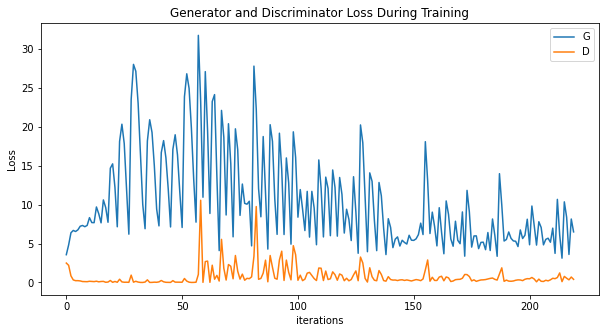

In [52]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

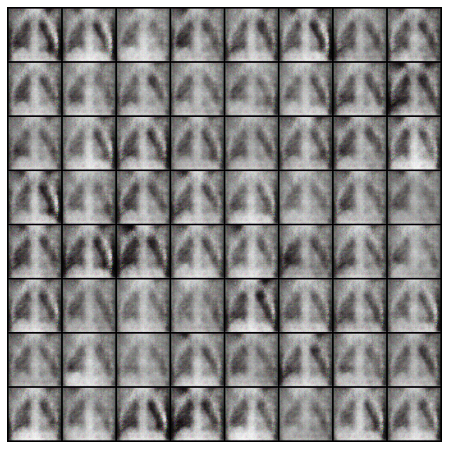

In [53]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

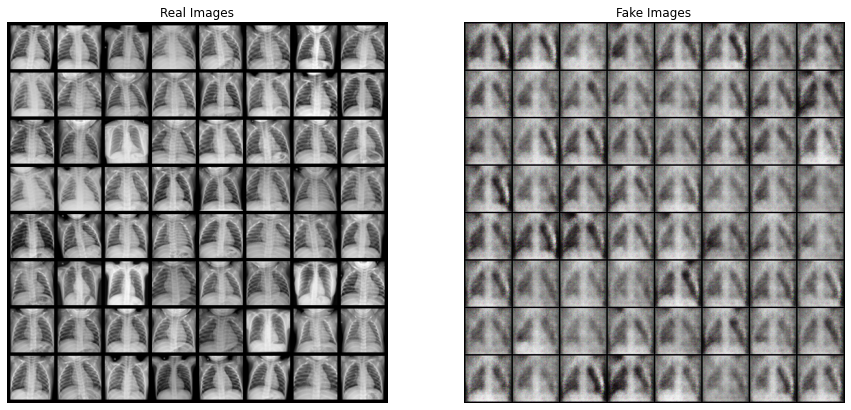

In [54]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [55]:
class Encoder(nn.Module):
    def __init__(self, ngpu):
        super(Encoder,self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 1, 3, bias = False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*8, ndf*16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*16, nz, 4, 2, 0, bias=False),
            nn.Tanh()
        )


    def forward(self, input):
        return self.main(input)

In [56]:
netE = Encoder(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netE = nn.DataParallel(netE, list(range(ngpu)))
netE.apply(weights_init)

netG.eval()
netD.eval()

criterion = nn.MSELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1
fake_label = 0


optimizerE = optim.Adam(netE.parameters(), lr=lr, betas=(beta1, 0.999))


img_list = []
E_losses = []
iters = 0

for epoch in range(num_epochs):
   
    for i, data in enumerate(dataloader, 0):
        real_image = data[0].to(device)

        optimizerE.zero_grad()
        z = netE(real_image)

        optimizerG.zero_grad()
        fake_image = netG(z)

        real_features = netD(real_image)
        fake_features = netD(fake_image)

        loss_imgs = criterion(real_image, fake_image)
        loss_features = criterion(fake_features, real_features)
        errE = loss_imgs + loss_features

        errE.backward()
        optimizerE.step()
        


        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_E: %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errE.item()))
        
        E_losses.append(errE.item())
        
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(netE(netG(fixed_noise))).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

[0/20][0/11]	Loss_E: 0.7476
[1/20][0/11]	Loss_E: 0.1407
[2/20][0/11]	Loss_E: 0.1238
[3/20][0/11]	Loss_E: 0.1008
[4/20][0/11]	Loss_E: 0.1020
[5/20][0/11]	Loss_E: 0.0967
[6/20][0/11]	Loss_E: 0.0931
[7/20][0/11]	Loss_E: 0.0919
[8/20][0/11]	Loss_E: 0.0944
[9/20][0/11]	Loss_E: 0.0811
[10/20][0/11]	Loss_E: 0.0787
[11/20][0/11]	Loss_E: 0.0823
[12/20][0/11]	Loss_E: 0.0786
[13/20][0/11]	Loss_E: 0.0872
[14/20][0/11]	Loss_E: 0.0852
[15/20][0/11]	Loss_E: 0.0792
[16/20][0/11]	Loss_E: 0.0884
[17/20][0/11]	Loss_E: 0.0805
[18/20][0/11]	Loss_E: 0.0774
[19/20][0/11]	Loss_E: 0.0824


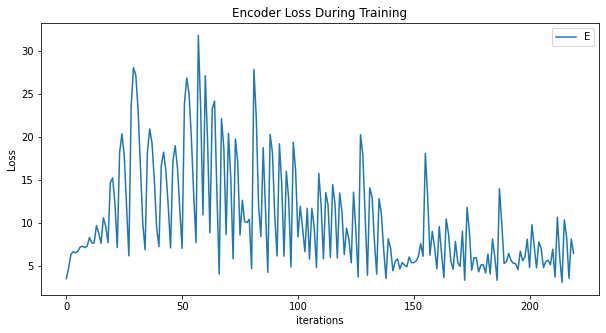

In [57]:
plt.figure(figsize=(10,5))
plt.title("Encoder Loss During Training")
plt.plot(G_losses,label="E")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

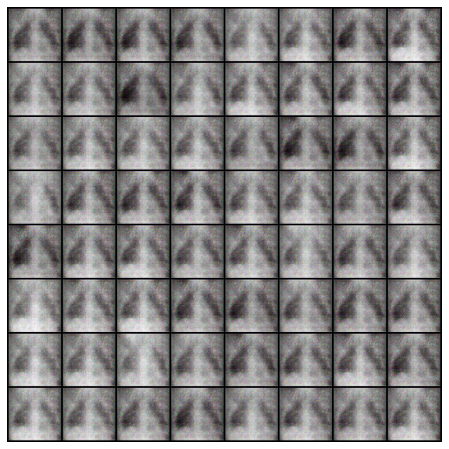

In [58]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

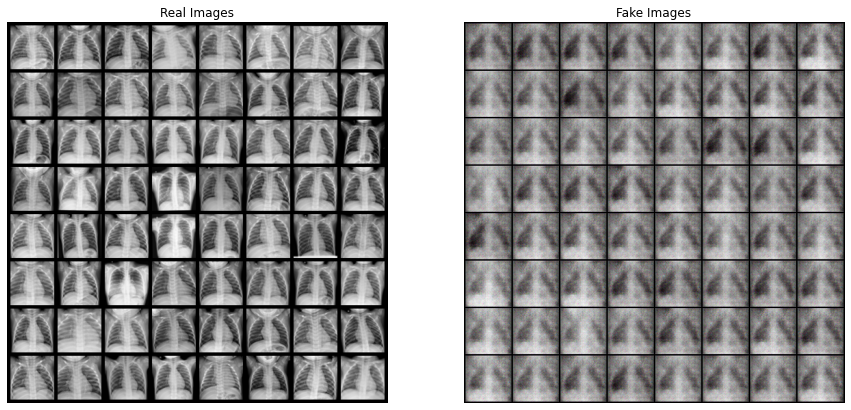

In [59]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [60]:
test_dataset = dset.ImageFolder(root='/content/chest_xray/test/',
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [61]:
def compare_images(real_img, generated_img, i, score, reverse=False, threshold=50):
    real_img = real_img.cpu().data.numpy()
    generated_img = generated_img.cpu().data.numpy()

    negative = np.zeros_like(real_img)

    if not reverse:
        diff_img = real_img - generated_img
    else:
        diff_img = generated_img - real_img
    
    diff_img[diff_img <= threshold] = 0

    anomaly_img = np.zeros_like(real_img)
    anomaly_img[:, :, 0] = real_img - diff_img
    anomaly_img[:, :, 1] = real_img - diff_img
    anomaly_img[:, :, 2] = real_img - diff_img
    anomaly_img[:, :, 0] = anomaly_img[:,:,0] + diff_img
    anomaly_img = anomaly_img.astype(np.uint8)

    fig, plots = plt.subplots(1, 4)
    fig.suptitle(f'Anomaly - (anomaly score: {score:.4})')
    
    fig.set_figwidth(9)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    plots[0].imshow(real_img, cmap='gray', label='real')
    plots[1].imshow(generated_img, cmap='gray')
    plots[2].imshow(diff_img, cmap='gray')
    plots[3].imshow(anomaly_img)
    
    plots[0].set_title('real')
    plots[1].set_title('generated')
    plots[2].set_title('difference')
    plots[3].set_title('Anomaly Detection')
    plt.show()

In [62]:
criterion = nn.MSELoss()
netG.eval()
netD.eval()
netE.eval()

with open("score.csv", "w") as f:
        f.write("label, img_distance,anomaly_score,z_distance\n")

for i, (data, label) in enumerate(test_dataloader,0):
    real_img = data.to(device)

    real_z = netE(real_img) # 진짜 이미지의 latent vector
    fake_img = netG(real_z) # G에 넣어서 가짜 이미지 생성.
    fake_z = netE(fake_img) # torch.Size([1, 100]) --> latent 진짜 이미지와 매핑된 가짜 이미지의 latent vector

    real_feature = netD(real_img) # 1, 256
    fake_feature = netD(fake_img)
    real_feature = real_feature / real_feature.max()
    fake_feature = fake_feature / fake_feature.max()
    # print("real_feature max : ",real_feature.max())
    # print("real_feature min : ",real_feature.min())
    # print("fake_feature max : ",fake_feature.max())
    # print("fake_feature min : ",fake_feature.min())

    img_distance = criterion(fake_img, real_img)
    loss_feature = criterion(fake_feature, real_feature)

    anomaly_score = img_distance + loss_feature

    z_distance = criterion(fake_z, real_z)
    
    with open("score.csv", "a") as f:
            f.write(f"{label}{img_distance},"
                    f"{anomaly_score},{z_distance}\n")
    
    if i % 2000 == 0:
        print(f"{img_distance}, "
          f"{anomaly_score}, {z_distance}\n")
        #compare_images(real_img, fake_img,i, anomaly_score, reverse = False, threshold = 80)

0.06457442790269852, 0.19727474451065063, 0.2872089445590973



In [63]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, precision_recall_curve, auc

In [64]:
df = pd.read_csv("score.csv")
df

label  ...  z_distance
tensor([1 0 0 1 1 1 1  1                      1.000000 0.000000 1.0 0.0 0.0 1.0 1.0  0                     0.000000 1.000000 0.0 1.0 1.0    1.0  ...         NaN
        0 0 1 0 1 1 1  1                      1.000000 1.000000 1.0 1.0 0.0 0.0 0.0  1                     1.000000 0.000000 1.0 0.0 0.0    0.0  ...         NaN
          1 0 0 1 1 0  1                      0.000000 0.000000 1.0 1.0 0.0 0.0 0.0  1                     1.000000 1.000000 0.0 0.0 0.0    1.0  ...         NaN
        1 1 1 1 0 0 1  0                      0.000000 0.000000 1.0 1.0 1.0 0.0 1.0  1                     1.000000 1.000000 1.0 1.0 1.0    1.0  ...         NaN
        0 0 1 1 1 1 0  1                      0.000000 0.000000 0.0 1.0 1.0 0.0 1.0  1                     1.000000 1.000000 0.0 0.0 0.0    1.0  ...         NaN
        1 1 1 1 1 1 1  0])0.06457442790269852 0.197275 0.287209 NaN NaN NaN NaN NaN NaN                    NaN      NaN      NaN NaN NaN    NaN  ...         NaN
tensor([0 0 1 0 1 0 0  1                      1.000000 1.000000 1.0 1.0 1.0 0.0 1.0  1                     1.000000 0.000000 1.0 0.0 1.0    1.0  ...         NaN
        1 1 1 0 0 1 0  0                      0.000000 1.000000 1.0 1.0 1.0 1.0 0.0  0                     1.000000 0.000000 1.0 0.0 1.0    1.0  ...         NaN
              1 1 0 0  1                      1.000000 1.000000 1.0 1.0 1.0 0.0 1.0  0                     0.000000 1.000000 1.0 0.0 1.0    1.0  ...         NaN
            0 0 1 1 1  1                      0.000000 1.000000 0.0 1.0 1.0 1.0 1.0  1                     1.000000 1.000000 1.0 1.0 0.0    0.0  ...         NaN
            1 1 1 0 1  1                      1.000000 0.000000 0.0 0.0 0.0 1.0 0.0  1                     1.000000 1.000000 0.0 0.0 1.0    1.0  ...         NaN
        0 1 0 1 1 1 0  1])0.06699855625629425 0.190359 0.288259 NaN NaN NaN NaN NaN NaN                    NaN      NaN      NaN NaN NaN    NaN  ...         NaN
tensor([1 0 0 1 1 1 1  1                      1.000000 1.000000 0.0 0.0 0.0 0.0 1.0  1                     1.000000 0.000000 1.0 1.0 0.0    1.0  ...         NaN
        0 0 0 1 1 1 0  1                      1.000000 1.000000 1.0 0.0 0.0 0.0 0.0  1                     1.000000 1.000000 0.0 1.0 0.0    1.0  ...         NaN
        1 1 0 0 1 1 0  1                      1.000000 0.000000 1.0 0.0 1.0 1.0 0.0  1                     1.000000 1.000000 0.0 0.0 1.0    1.0  ...         NaN
              1 0 1 0  1                      1.000000 1.000000 0.0 1.0 1.0 1.0 0.0  1                     0.000000 1.000000 1.0 0.0 1.0    1.0  ...         NaN
        0 1 1 1 1 1 0  1                      1.000000 1.000000 0.0 1.0 1.0 1.0 1.0  0                     1.000000 1.000000 1.0 0.0 0.0    0.0  ...         NaN
        1 1 0 1 1 1 1  1])0.06384915113449097 0.151141 0.277502 NaN NaN NaN NaN NaN NaN                    NaN      NaN      NaN NaN NaN    NaN  ...         NaN
tensor([1 0 1 0 1 1 1  1                      1.000000 1.000000 1.0 0.0 0.0 0.0 1.0  0                     0.000000 0.000000 1.0 0.0 1.0    1.0  ...         NaN
        0 0 1 0 1 0 0  1                      0.000000 0.000000 1.0 0.0 0.0 1.0 0.0  1                     1.000000 1.000000 0.0 1.0 1.0    0.0  ...         NaN
        1 1 0 0 0 1 1  0                      1.000000 1.000000 0.0 1.0 0.0 1.0 1.0  1                     1.000000 0.000000 1.0 1.0 1.0    1.0  ...         NaN
        0 0 1 1 1 1 1  0                      0.000000 1.000000 0.0 0.0 0.0 1.0 1.0  0                     1.000000 1.000000 1.0 0.0 1.0    1.0  ...         NaN
          1 1 1 1 1 1  1                      0.000000 1.000000 1.0 1.0 0.0 1.0 1.0  1                     1.000000 1.000000 1.0 0.0 1.0    1.0  ...         NaN
        1 0 1 1 1 1 0  0])0.06537224352359772 0.176284 0.272882 NaN NaN NaN NaN NaN NaN                    NaN      NaN      NaN NaN NaN    NaN  ...         NaN
tensor([1 1 1 0 1 1 0  0                      1.000000 0.000000 1.0 0.0 1.0 1.0 1.0  0                     0.0000